In [210]:
import numpy as np
import jax.numpy as jnp
import circuitmap as cm

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [4]:
demixer = cm.NeuralDemixer()
demixer.generate_training_data(size=2000, training_fraction=1.0, noise_std_upper=0.02, gp_lengthscale=50)

Trace generation:   0%|          | 0/2000 [00:00<?, ?it/s]

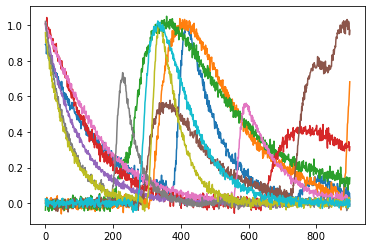

In [5]:
inputs, targets = demixer.training_data
plt.plot(inputs[0:10,:].T)

In [213]:
def _sample_gp(trial_dur=800, gp_lengthscale=25, gp_scale=0.01, n_samples=1):
	D = np.array([[i - j for i in range(trial_dur)] for j in range(trial_dur)])
	K = np.exp(-D**2/(2 * gp_lengthscale**2))
	mean = np.zeros(trial_dur)
	return gp_scale * np.random.multivariate_normal(mean, K, size=n_samples)

def _sample_photocurrent_params(stim_off_current_min=0.02,
                                stim_off_current_max=0.1,
                                tau_r_min=100,
                                tau_r_max=200,
                                tau_d_min=50,
                                tau_d_max=100):
    return dict(
        stim_off_current = np.random.uniform(low=stim_off_current_min, high=stim_off_current_max,),
        tau_r            = np.random.uniform(low=tau_r_min, high=tau_r_max,),
        tau_d            = np.random.uniform(low=tau_d_min, high=tau_d_max)
    )

def gen_photocurrent_waveform(stim_on=100, stim_off=200, trial_dur=900, stim_off_current=0.07, tau_r=130, tau_d=300):
    out = np.zeros(trial_dur)
    x = np.arange(trial_dur)

    # make linear rise from stim on to stim off
    out[stim_on:stim_off] = np.linspace(start=0, stop=stim_off_current, num=(stim_off - stim_on))

    # calculate offset for continuity
    delta = stim_on
    pc_shape = (tau_d * tau_r / (tau_d - tau_r)) * (np.exp(-(x - delta)/tau_d) - np.exp(-(x - delta)/tau_r)) * (x >= delta)
    pc_shape /= np.max(pc_shape)
    pc_shape *= stim_off_current / pc_shape[stim_off]
    out[stim_off:] = pc_shape[stim_off:]

    # add GP to photocurrent shape for added variability
    gp = np.squeeze(_sample_gp(trial_dur=900, gp_scale=0.002, gp_lengthscale=100))
    gp += np.squeeze(_sample_gp(trial_dur=900, gp_scale=0.001, gp_lengthscale=10))
    out += gp
    out = np.maximum(0, out)
    out[0:stim_on] = 0

    # ensure waveform is monotonically decreasing after 400 frames 
    out =  np.squeeze(cm.neural_waveform_demixing._monotone_decay_filter(out[None,:], monotone_start=400, inplace=False))

    # convolve with gaussian to smooth the edges
    return gaussian_filter1d(out, sigma=10)
    

Text(0, 0.5, 'photocurrent')

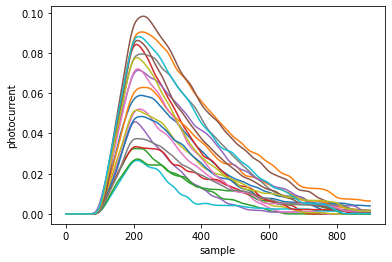

In [214]:
xs = np.array([gen_photocurrent_waveform(**_sample_photocurrent_params()) for _ in range(20)])
plt.plot(xs.T)
plt.xlabel('sample')
plt.ylabel('photocurrent')


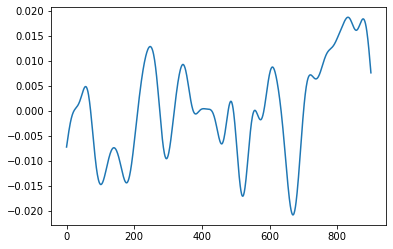

In [151]:
plt.plot(gp.T)